# NLP

In [1]:
import nltk
import pandas as pd
import chardet
from matplotlib import pyplot as plt
import re
import seaborn as sns
import numpy as np
from statsmodels import api as sm
from wordcloud import WordCloud
from collections import Counter
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import sklearn
import networkx as nx

In [2]:
# Download nltk data; turn to true if first time
if False:
    nltk.download()

In [3]:
sns.set_theme(color_codes = True)

### Inputs

In [4]:
# Text Laguage
language = 'english'

# Figure default size
plt.rcParams['figure.figsize'] = (10, 5)

### Detect Encoding

In [5]:
with open('Harry Potter and the Sorcerer.txt', 'rb') as f:
    
    e = chardet.detect(f.read())
    
    print(e)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


### Load File

In [6]:
with open('Harry Potter and the Sorcerer.txt', 'r', encoding = e['encoding']) as f:
    
    text = f.read()
    
print(text[:200])

Harry Potter and the Sorcerer's Stone 

CHAPTER ONE 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. Th


### Word Cloud

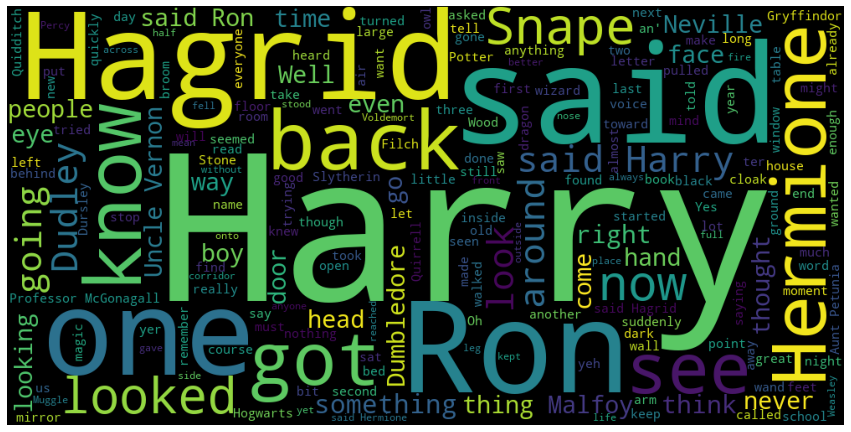

In [7]:
wc = WordCloud(width = 1000, height = 500).generate_from_text(text)

plt.figure(figsize=(15,8))

plt.imshow(wc)
plt.axis("off")
plt.show()

### Split chapters

In [8]:
chapters = re.split('\n\nCHAPTER \w+ \n\n', text)[1:]

chapters_pd = pd.DataFrame(
    ['\n'.join(i.split('\n\n')[1:]) for i in chapters],
    index = [i.split('\n\n')[0] for i in chapters]

)

chapters_pd

,0
THE BOY WHO LIVED,"Mr. and Mrs. Dursley, of number four, Privet D..."
THE VANISHING GLASS,Nearly ten years had passed since the Dursleys...
THE LETTERS FROM NO ONE,The escape of the Brazilian boa constrictor ea...
THE KEEPER OF THE KEYS,BOOM. They knocked again. Dudley jerked awake....
DIAGON ALLEY,Harry woke early the next morning. Although he...
THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS,Harry's last month with the Dursleys wasn't fu...
THE SORTING HAT,"The door swung open at once. A tall, black-hai..."
THE POTIONS MASTER,"There, look."" \n""Where?"" \n""Next to the tall k..."
HALLOWEEN,Malfoy couldn't believe his eyes when he saw t...
QUIDDITCH,"As they entered November, the weather turned v..."


Create tokens

In [65]:
stop_words = set(nltk.corpus.stopwords.words(language))

remove_puctuation = lambda a: [i for i in a if i.isalnum()]

chapters_token = [
    remove_puctuation(
        # Tokenize and make lower case
        nltk.tokenize.word_tokenize(s.lower()) 
        )
    for s in chapters 
    # Filter stop words
    if s not in stop_words
]

Create gensim dictionary

In [86]:
dictionary = gensim.corpora.Dictionary(chapters_token)

Create Corpus

In [87]:
corpus = [dictionary.doc2bow(s) for s in chapters_token]

### TF IDF

In [12]:
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus)

In [13]:
n_chapter = 5
n = 10

for i in pd.DataFrame(tfidf[corpus[n_chapter]]).sort_values(1, ascending = False)[:n].iterrows():
    print(f'{dictionary[i[0]]}: {i[1][1]:.3f}')

undursleyish: 0.340
wanted: 0.242
repeated: 0.233
sleeve: 0.227
along: 0.151
uneasy: 0.151
louder: 0.148
stupid: 0.132
youknow-who: 0.132
well: 0.126


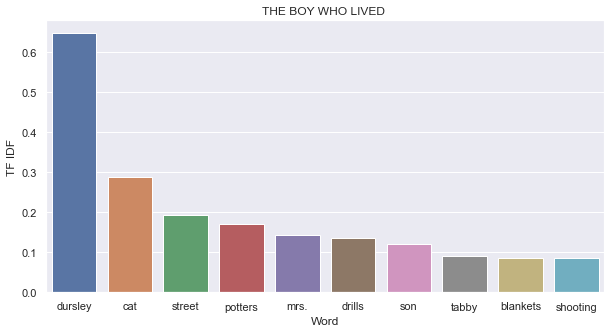

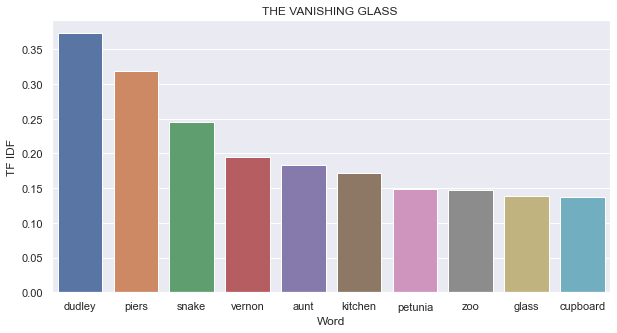

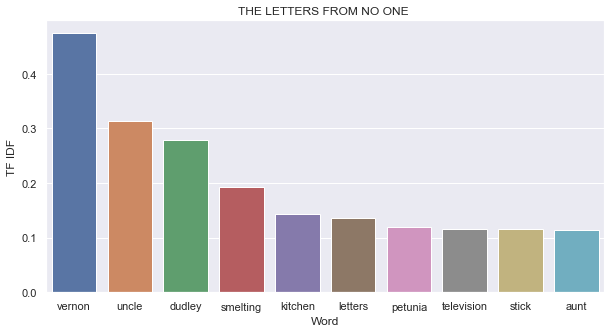

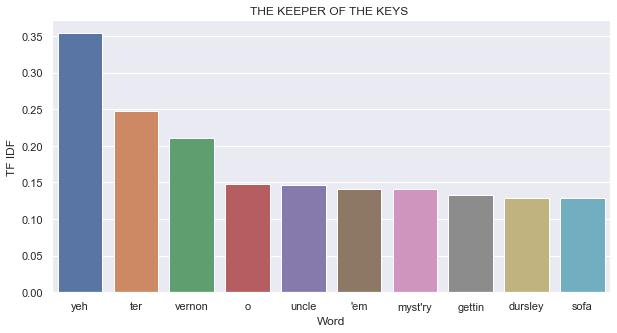

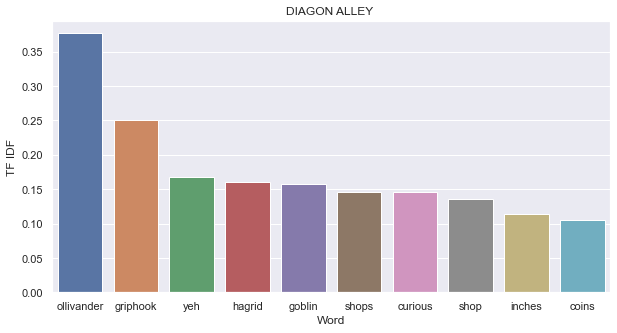

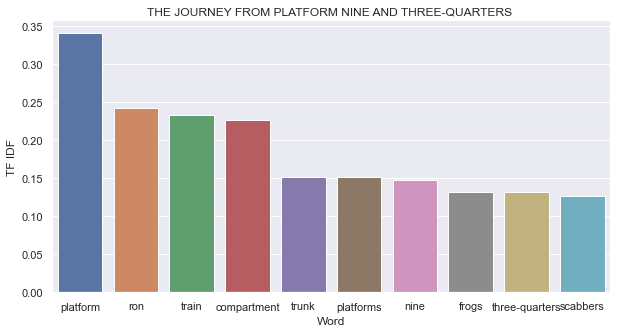

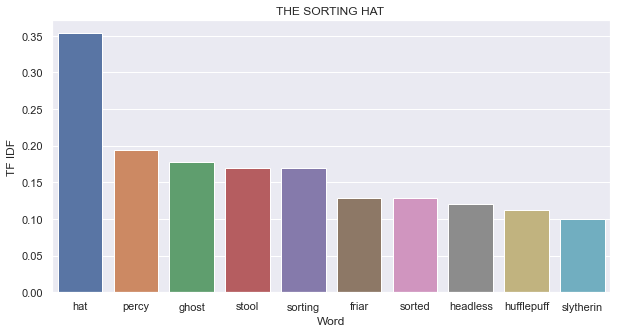

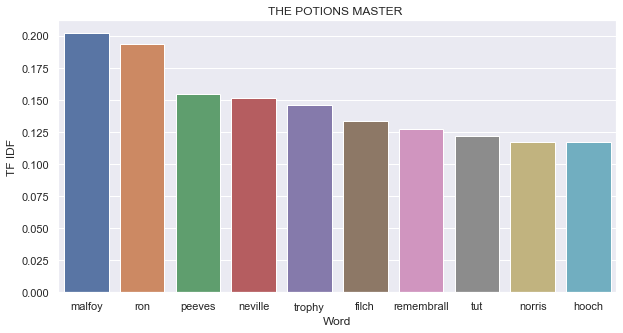

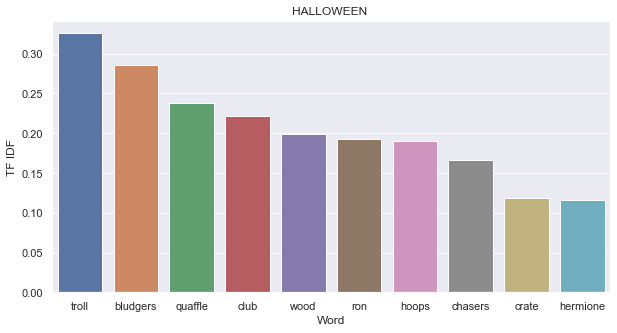

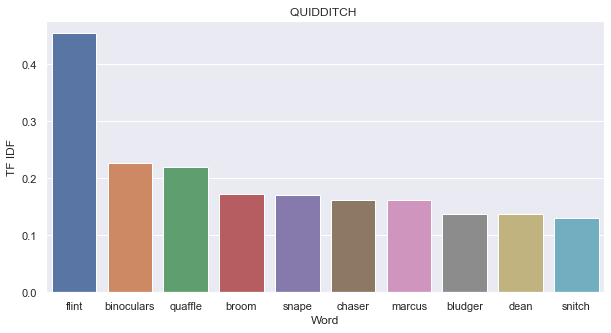

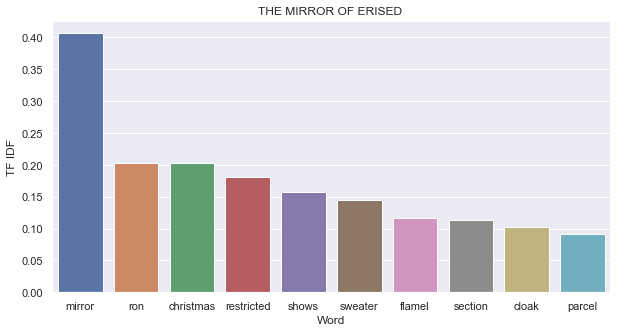

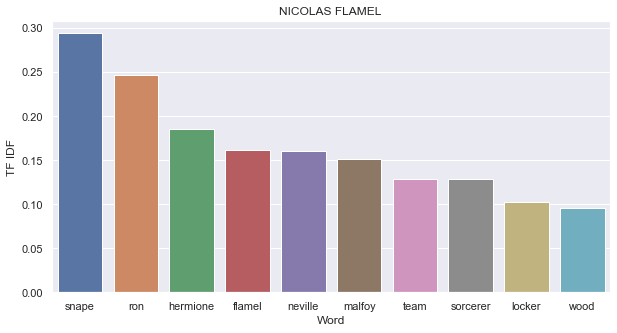

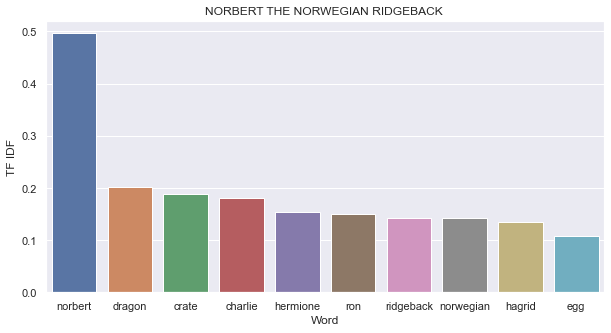

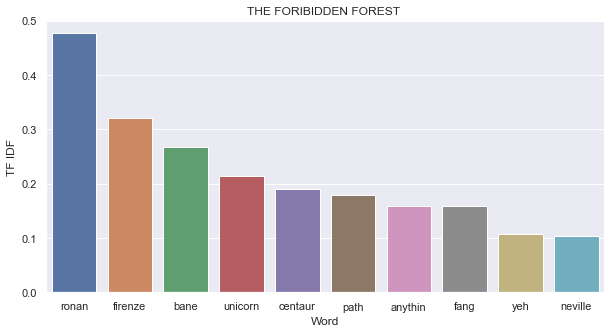

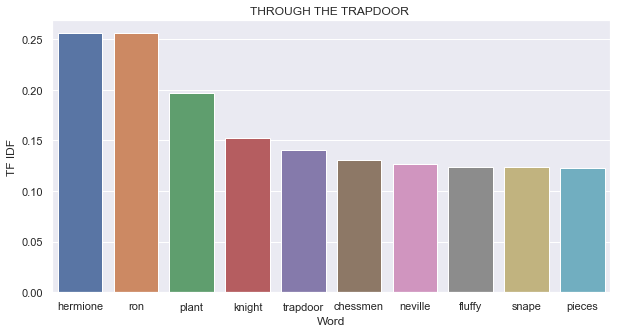

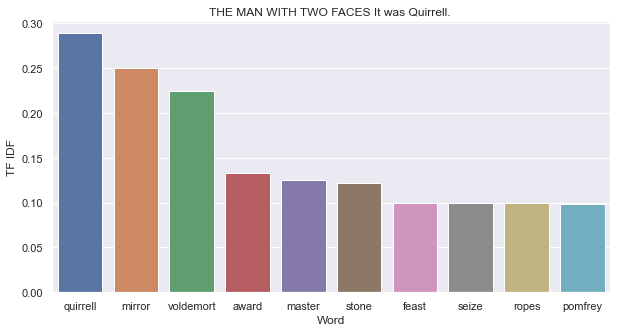

In [16]:
for n_chapter in range(len(corpus)):
    
    # Number of words to display
    n = 10

    df = pd.DataFrame(tfidf[corpus[n_chapter]])\
        .sort_values(1, ascending = False)\
        .set_axis(axis = 1, labels = ['Word', 'TF IDF'])

    df['Word'] = df['Word'].apply(lambda a: dictionary[a])
    
    sns.barplot(data = df[:n], x = 'Word', y = 'TF IDF')
    
    plt.title(chapters[n_chapter].split('\n')[0])

    plt.show()

#### TF IDF Sklearn

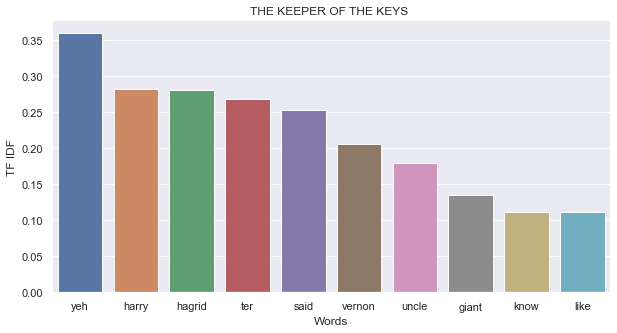

In [17]:
tfidf_vectorizer  = TfidfVectorizer(stop_words = 'english')

tfidf = tfidf_vectorizer.fit_transform(chapters)

n_chapter = 3
n = 10


df = pd.DataFrame(
    {'Words':tfidf_vectorizer.get_feature_names(), 
     'TF IDF':tfidf.toarray()[n_chapter]}
    )\
    .sort_values('TF IDF', ascending = False)

sns.barplot(data = df[:n], x = 'Words', y = 'TF IDF')

plt.title(chapters[n_chapter].split('\n')[0])

plt.show()

### Word Embedding

In [21]:
# Select only words, remove punctuation
fn =  lambda a: [s for s in a if s.isalnum()]


# Creat a corpus with all sentences
t = [
        fn(nltk.word_tokenize(i.lower())) 
        # Split with \n
        for i in text.split('\n') 
        # Remove empty sentences
        if len(i) > 0 
        # Remove stop words
        and i not in stop_words
]

# Create word2vec model
word2vec = gensim.models.Word2Vec(t, min_count=2)

# Create weights
x = word2vec[word2vec.wv.vocab]

# Create dataframe
df = pd.DataFrame(x, index = word2vec.wv.vocab)

df.head()

<ipython-input-21-0b6ef93b2fdf>:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x = word2vec[word2vec.wv.vocab]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
harry,0.304740,-0.044015,-0.544751,-0.053048,0.111134,-0.475535,-0.438866,0.159995,0.494556,-0.689316,...,0.470777,0.499141,0.354197,-1.242166,1.168171,0.658546,0.060822,0.556555,0.153975,-0.146438
potter,0.226289,-0.036940,-0.426557,-0.028698,0.099686,-0.366893,-0.322735,0.128200,0.388859,-0.521265,...,0.374599,0.381985,0.267716,-0.949132,0.906967,0.496765,0.052322,0.417383,0.131738,-0.122035
and,0.316921,-0.046069,-0.629741,-0.063319,0.113393,-0.518494,-0.503206,0.181550,0.546978,-0.774538,...,0.529146,0.572257,0.401256,-1.402668,1.308812,0.769869,0.061465,0.627808,0.170982,-0.156572
the,0.287363,-0.041154,-0.562286,-0.071283,0.087241,-0.457737,-0.465016,0.163525,0.504650,-0.715287,...,0.474329,0.518232,0.366890,-1.254892,1.172792,0.714589,0.035954,0.576154,0.134812,-0.134421
sorcerer,0.051786,-0.012591,-0.096030,-0.013363,0.018277,-0.081094,-0.079677,0.032302,0.087133,-0.121166,...,0.085333,0.092544,0.061693,-0.219385,0.202528,0.116327,0.009066,0.100865,0.025700,-0.024688


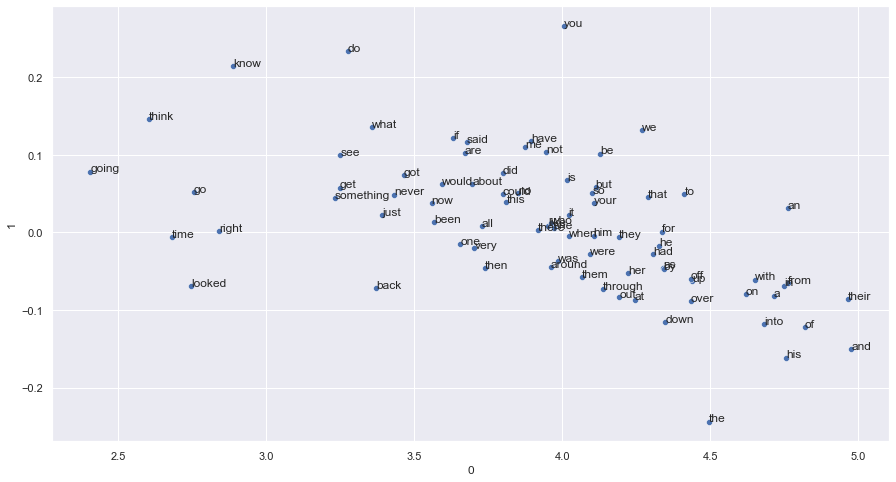

In [22]:
# Tokenize text
token = nltk.tokenize.word_tokenize(text, language = language)

# Select most common words
slicer = [
        a[0] for a in Counter(token).most_common()
        # only words in the dataframe
        if a[0] in df.index
    ][:80] # First n words

# Create PCA model
pca = PCA(n_components=2)

# Fit model
transform = pca.fit_transform(df)

# Create dataframe with results
df_new = pd.DataFrame(transform, index=df.index).loc[slicer]

# Plot size
plt.figure(figsize=(15,8))

# Plot PCA result
sns.scatterplot(x = df_new[0], y = df_new[1]
)

# Plot Labels
for pos, name in zip(df_new.values, slicer):
    
    plt.annotate(name,xy=(pos[0],pos[1]))

plt.show()

#### Word Embedding Names

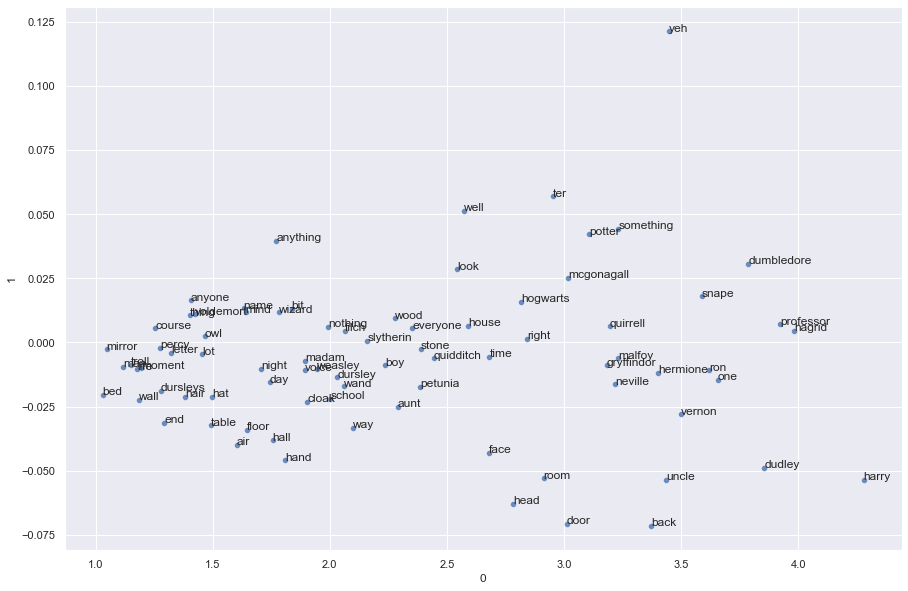

In [23]:
# Select all names
names = [i[0].lower() for i in nltk.pos_tag(token) if i[1] == 'NNP' or i[1] == 'NN']

# Select most common words
slicer = [
        a[0] for a in Counter(names).most_common()
        # only words in the dataframe
        if a[0] in df.index
    ][:80] # First n words

# Create PCA model
pca = PCA(n_components=2)

# Fit model
transform = pca.fit_transform(df)

# Create dataframe with results
df_new = pd.DataFrame(transform, index=df.index).loc[slicer]

# Plot size
plt.figure(figsize=(15,10))

# Plot PCA result
sns.scatterplot(x = df_new[0], y = df_new[1], alpha = 0.8
)

# Plot Labels
for pos, name in zip(df_new.values, slicer):
    
    plt.annotate(name,xy=(pos[0],pos[1]))

plt.show()

### Tokenize Text

In [24]:
token = nltk.tokenize.word_tokenize(text.lower(), language = language)

token[:5]

['harry', 'potter', 'and', 'the', 'sorcerer']

### Remove punctuation

In [25]:
token = [word for word in token if word.isalnum()]

### Get Frequency distribution

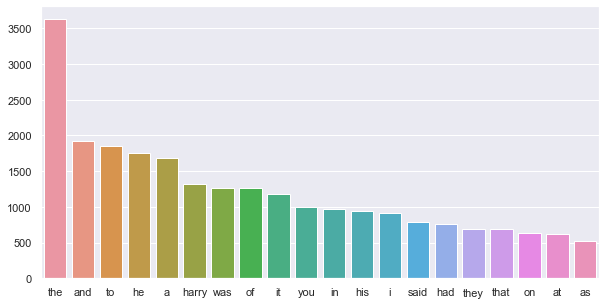

In [26]:
w = Counter(token).most_common()[:20] # First N words

sns.barplot(
    x = [a[0] for a in w],
    y = [a[1] for a in w]
)

plt.show()

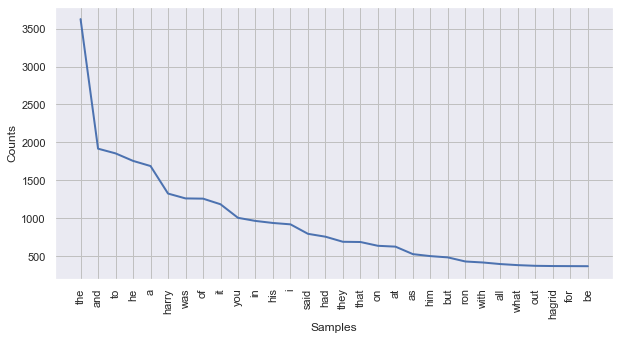

In [27]:
# Create Frequency distribution
fdist = nltk.probability.FreqDist(token)

fdist.plot(30, cumulative = False)

plt.show()

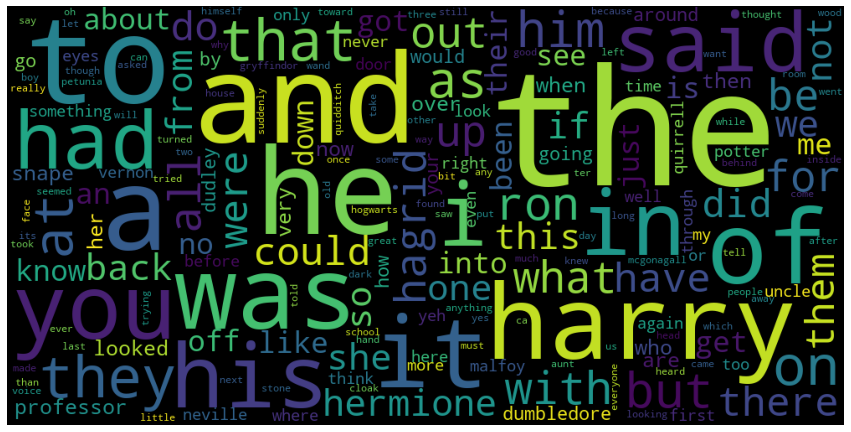

In [28]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(fdist)

plt.figure(figsize=(15,8))

plt.imshow(wc)
plt.axis("off")
plt.show()

### Zipf's Law

In [29]:
def zipf_law(fdist):
    
    # Sort Frequencies
    freq = np.sort(np.array(
        list(
            fdist.values()
            )
        ))[::-1]
    
    r = np.arange(1, len(freq) + 1)
    
    # Plot Results
    sns.regplot(
        # Frequency
        y = np.log(freq),
        # Rank
        x = np.log(r), 
    )


    plt.ylabel('Log(Frequency)')

    plt.xlabel('Log(r)')

    plt.show()
    
    # Linear Regression
    lm = sm.OLS(
        # Frequency
        np.log(freq),
        # Rank
        np.log(r)
    )

    result = lm.fit()

    print(result.summary())

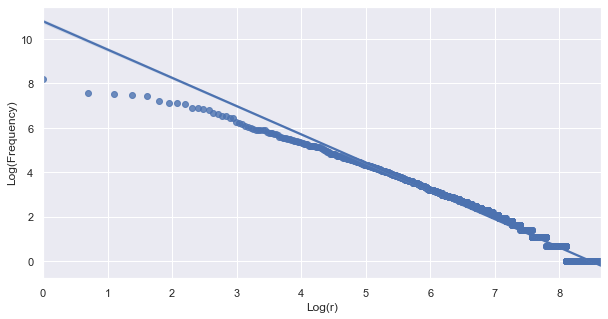

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.286
Method:                 Least Squares   F-statistic:                              2271.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        23:05:20   Log-Likelihood:                         -10005.
No. Observations:                5676   AIC:                                  2.001e+04
Df Residuals:                    5675   BIC:                                  2.002e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [30]:
zipf_law(fdist)

### NER - Named Entity Recognition

In [31]:
ner = nltk.pos_tag(token)

print(ner[:5])

[('harry', 'NN'), ('potter', 'NN'), ('and', 'CC'), ('the', 'DT'), ('sorcerer', 'NN')]


### Remove Stop Words

In [32]:
# Select all stop words
stop_words = set(nltk.corpus.stopwords.words(language))

# Filter stop words
token_stop = [w for w in token if w not in stop_words]

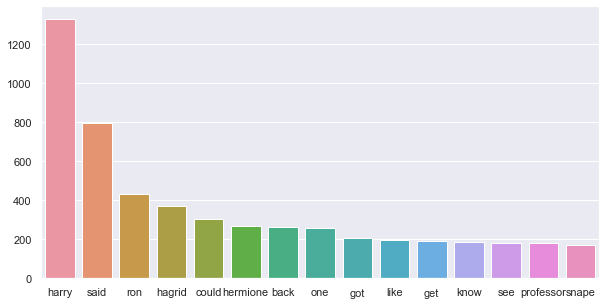

In [33]:
w = Counter(token_stop).most_common()[:15] # First N words

sns.barplot(
    x = [a[0] for a in w],
    y = [a[1] for a in w]
)

plt.show()

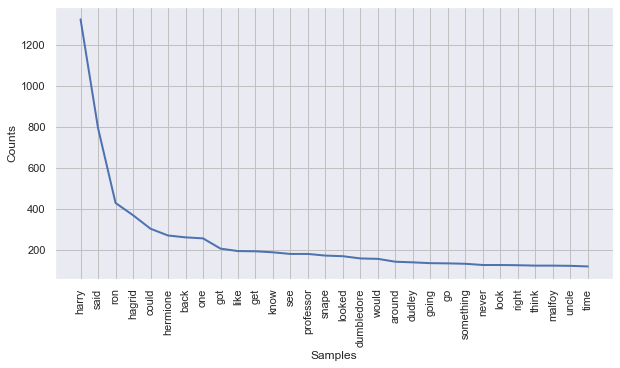

In [46]:
fdist = nltk.probability.FreqDist(token_stop)

fdist.plot(30, cumulative = False)

plt.show()

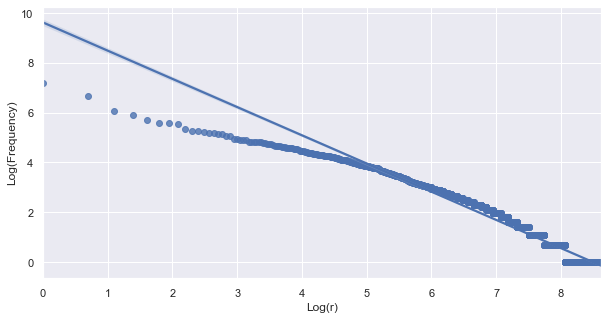

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.299
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              2367.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        23:05:26   Log-Likelihood:                         -9185.1
No. Observations:                5540   AIC:                                  1.837e+04
Df Residuals:                    5539   BIC:                                  1.838e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [35]:
zipf_law(fdist)

### Stemming

In [36]:
ps = nltk.stem.PorterStemmer()

token_stemmming = [ps.stem(s) for s in token_stop]

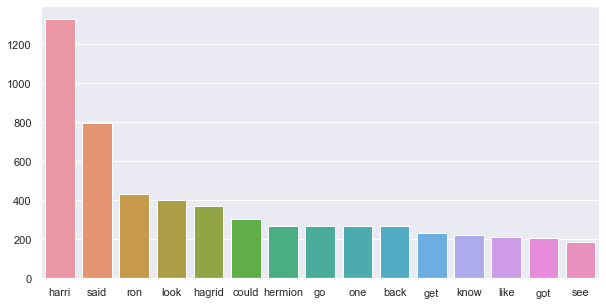

In [37]:
w = Counter(token_stemmming).most_common()[:15] # First N words

sns.barplot(
    x = [a[0] for a in w],
    y = [a[1] for a in w]
)

plt.show()

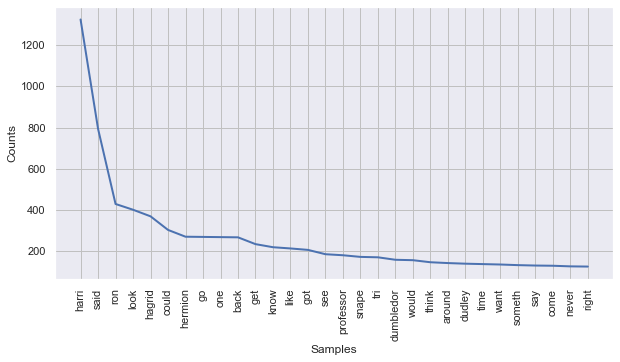

In [45]:
fdist = nltk.probability.FreqDist(token_stemmming)

fdist.plot(30, cumulative = False)

plt.show()

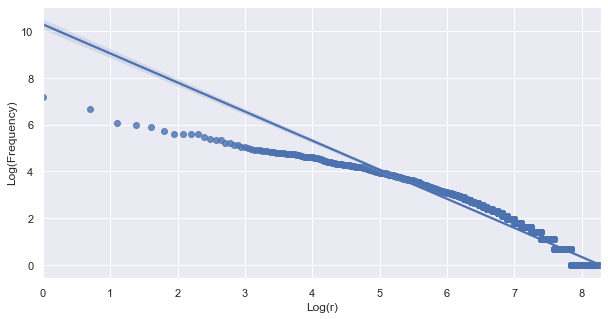

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.349
Model:                            OLS   Adj. R-squared (uncentered):              0.348
Method:                 Least Squares   F-statistic:                              2119.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        23:05:29   Log-Likelihood:                         -7031.0
No. Observations:                3962   AIC:                                  1.406e+04
Df Residuals:                    3961   BIC:                                  1.407e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [39]:
zipf_law(fdist)

### N-grams

In [40]:
vect = CountVectorizer(input = token, ngram_range = (2, 3))

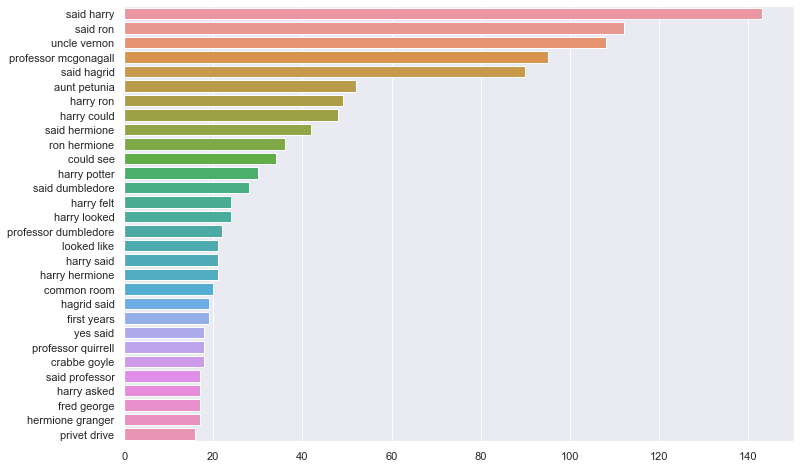

In [41]:
plt.figure(figsize=(12,8))

w = Counter(nltk.ngrams(token_stop, 2)).most_common()[:30]

sns.barplot(
    y = [' '.join(a[0]) for a in w],
    x = [a[1] for a in w],orient = 'h'
)

plt.show()

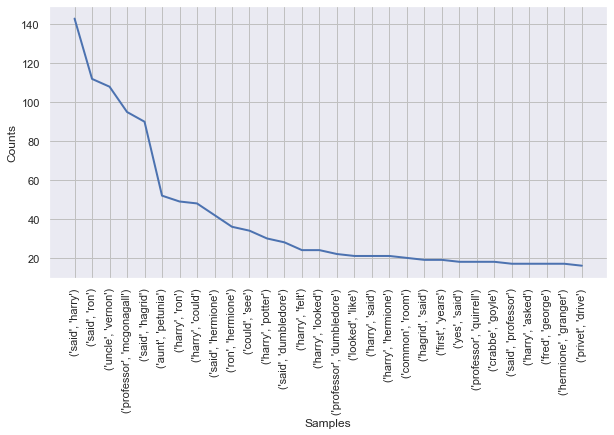

In [42]:
fdist = nltk.probability.FreqDist(nltk.ngrams(token_stop, 2))

fdist.plot(30, cumulative = False)

plt.show()

### Graph using n Grams

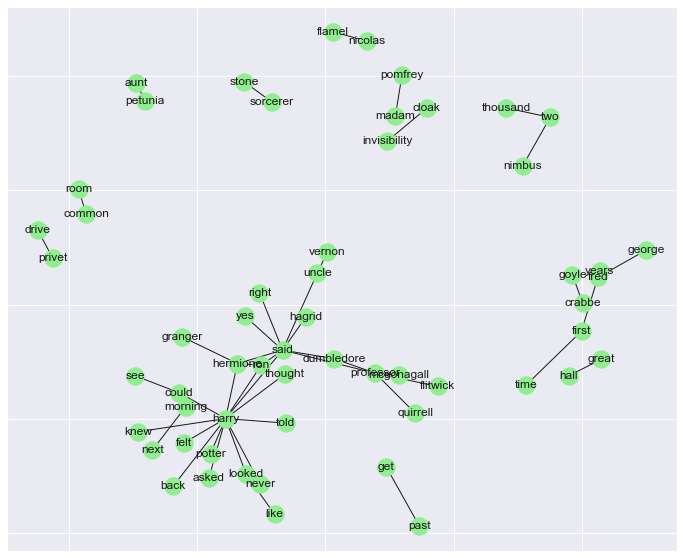

In [43]:
# Only N monst commen ngrams
n = 50

G = nx.Graph()

for i in Counter(nltk.ngrams(token_stop, 2)).most_common()[:n]:
    
    G.add_edge(i[0][0], i[0][1], weight = i[1])


plt.figure(figsize=(12,10))

pos = (nx\
    #.planar_layout(G)\
    .spring_layout(G, k=0.7, scale=0.05)
    #.circular_layout(G)
    #.planar_layout(G)
    #.random_layout(G)
    #.spiral_layout(G)
      )

nx.draw_networkx(G, pos=pos, node_color='lightgreen')

plt.show()

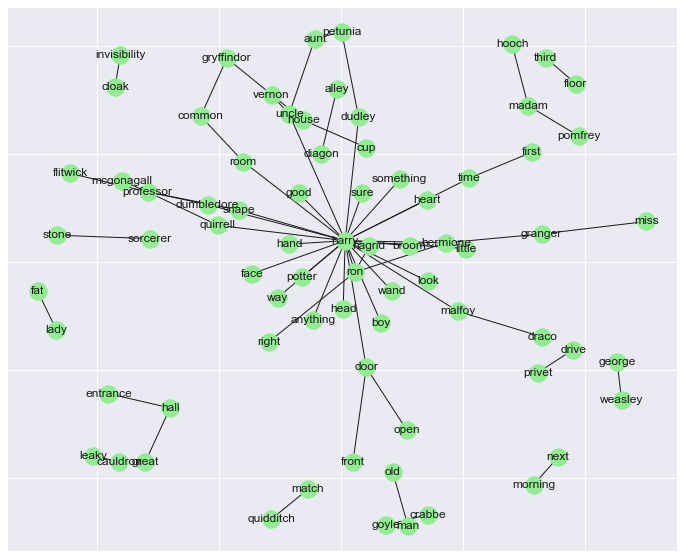

In [44]:
# Only N monst commen ngrams
n = 75

G = nx.Graph()

token_name = [i[0] for i in nltk.pos_tag(token_stop) if i[1] == 'NNP' or i[1] == 'NN' or i[1] == 'JJ']

for i in Counter(nltk.ngrams(token_name, 2)).most_common()[:n]:
    
    G.add_edge(i[0][0], i[0][1], weight = i[1])


plt.figure(figsize=(12,10))

pos = (nx\
    #.planar_layout(G)\
    .spring_layout(G, k=0.7, scale=0.05)
    #.circular_layout(G)
    #.planar_layout(G)
    #.random_layout(G)
    #.spiral_layout(G)
      )

nx.draw_networkx(G, pos=pos, node_color='lightgreen')

plt.show()

### Topic modeling

In [66]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = gensim.corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [69]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    
    lsamodel = gensim.models.LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    #print(lsamodel.print_topics(num_topics=number_of_topics, num_words = words))
    return lsamodel

lsi = create_gensim_lsa_model(chapters_token, 5, 100)

In [95]:
lsamodel = gensim.models.LsiModel(corpus = corpus, num_topics = 7, id2word = dictionary)

In [96]:
for i in lsamodel.print_topics():
    print('Topic: ', i[0])
    print(i[1])
    print('-' * 60)

Topic:  0
0.536*"the" + 0.290*"and" + 0.279*"to" + 0.255*"he" + 0.252*"a" + 0.199*"harry" + 0.190*"of" + 0.186*"was" + 0.173*"it" + 0.157*"you"
------------------------------------------------------------
Topic:  1
-0.318*"you" + -0.278*"ron" + 0.277*"he" + -0.268*"to" + -0.243*"hermione" + 0.239*"dudley" + 0.225*"a" + -0.217*"i" + 0.209*"his" + 0.175*"vernon"
------------------------------------------------------------
Topic:  2
-0.398*"i" + 0.357*"the" + -0.316*"hagrid" + -0.245*"he" + -0.184*"said" + -0.178*"yeh" + 0.162*"ron" + -0.150*"a" + -0.140*"quirrell" + -0.135*"an"
------------------------------------------------------------
Topic:  3
-0.391*"hagrid" + 0.328*"he" + -0.258*"a" + 0.216*"his" + -0.209*"they" + -0.204*"harry" + 0.173*"dumbledore" + 0.161*"i" + 0.155*"quirrell" + 0.141*"him"
------------------------------------------------------------
Topic:  4
0.368*"harry" + 0.229*"vernon" + 0.217*"uncle" + -0.214*"that" + -0.210*"a" + 0.206*"dudley" + -0.189*"professor" + -0.1

In [68]:
lsi.print_topics()

[(0,
  '0.536*"the" + 0.290*"and" + 0.279*"to" + 0.255*"he" + 0.252*"a" + 0.199*"harry" + 0.190*"of" + 0.186*"was" + 0.173*"it" + 0.157*"you"'),
 (1,
  '-0.318*"you" + -0.278*"ron" + 0.277*"he" + -0.268*"to" + -0.243*"hermione" + 0.239*"dudley" + 0.225*"a" + -0.217*"i" + 0.209*"his" + 0.175*"vernon"'),
 (2,
  '-0.398*"i" + 0.357*"the" + -0.316*"hagrid" + -0.245*"he" + -0.184*"said" + -0.178*"yeh" + 0.162*"ron" + -0.150*"a" + -0.140*"quirrell" + -0.135*"an"'),
 (3,
  '-0.391*"hagrid" + 0.328*"he" + -0.258*"a" + 0.216*"his" + -0.209*"they" + -0.204*"harry" + 0.173*"dumbledore" + 0.161*"i" + 0.155*"quirrell" + 0.141*"him"')]

In [80]:
t = lsi.get_topics()

In [82]:
t[0]

array([2.51697028e-01, 3.89287200e-03, 3.29233627e-02, ...,
       1.50986188e-04, 1.50986188e-04, 1.50986188e-04])

In [79]:
lsi.print_topics()

[(0,
  '0.536*"the" + 0.290*"and" + 0.279*"to" + 0.255*"he" + 0.252*"a" + 0.199*"harry" + 0.190*"of" + 0.186*"was" + 0.173*"it" + 0.157*"you"'),
 (1,
  '0.318*"you" + 0.278*"ron" + -0.277*"he" + 0.268*"to" + 0.243*"hermione" + -0.239*"dudley" + -0.225*"a" + 0.217*"i" + -0.209*"his" + -0.175*"vernon"'),
 (2,
  '0.398*"i" + -0.357*"the" + 0.316*"hagrid" + 0.245*"he" + 0.184*"said" + 0.178*"yeh" + -0.162*"ron" + 0.150*"a" + 0.140*"quirrell" + 0.135*"an"'),
 (3,
  '0.391*"hagrid" + -0.328*"he" + 0.258*"a" + -0.216*"his" + 0.209*"they" + 0.204*"harry" + -0.173*"dumbledore" + -0.161*"i" + -0.155*"quirrell" + -0.141*"him"'),
 (4,
  '-0.368*"harry" + -0.229*"vernon" + -0.217*"uncle" + 0.214*"that" + 0.210*"a" + -0.206*"dudley" + 0.189*"professor" + 0.187*"dursley" + -0.173*"said" + 0.173*"mcgonagall"')]

### Sentiment Analysis